In [1]:
# Enable auto-reloading of imports when they have been modified
from IPython import get_ipython
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os
import json
import torch
import torch.nn as nn

# Disable gradient computation - this notebook will only perform forward passes
torch.set_grad_enabled(False)

from pathlib import Path
import sys
import os

# Add the base (root) directory to the path so we can import the util modules
def get_base_folder(project_root = "Count_PIPNet"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return Path(current_dir)

base_path = get_base_folder("PIPNet") #"PIPNet"
print(f"Base path: {base_path}")
sys.path.append(str(base_path))

Base path: C:\Edu\Mech_Interp\PIPNet


In [2]:
from util.vis_pipnet import vizualize_network
from pipnet.count_pipnet import get_count_network
from util.checkpoint_manager import CheckpointManager
from util.data import get_dataloaders
from util.args import get_args
from util.vis_pipnet import vizualize_network

In [3]:
# Device setup
GPU_TO_USE = 0

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f'>>> Using {device} device <<<')

>>> Using cuda:0 device <<<


In [4]:
use_multi_experiment_dir = True

multi_experiment_dir = base_path / 'runs/final'
multi_experiment_dir

WindowsPath('C:/Edu/Mech_Interp/PIPNet/runs/final')

In [5]:
visualization_dir = base_path / 'visualizations'
os.makedirs(visualization_dir, exist_ok=True)

In [6]:
summary_path = os.path.join(multi_experiment_dir, 'summary.json')

try:
	# Load the summary file to get all run directories
	with open(summary_path, 'r') as f:
		summary = json.load(f)

	print(f"Found {len(summary)} trained models")
except FileNotFoundError:
	print(f"Summary file NOT found at {summary_path}. Please ensure the training was completed and the summary file was generated.")

Found 2 trained models


# Loading the model

In [7]:
def load_model(run_dir, checkpoint_name='net_trained_best', base_path=base_path, gpu_id=3):
	"""
	Load a model from a checkpoint directory for visualization purposes.

	Args:
		run_dir: Directory containing the run results
		checkpoint_name: Name of checkpoint to load (default: 'net_trained_best')
		base_path: Base path for dataset directories (default: None)
		gpu_id: GPU ID to use (default: 0)
		
	Returns:
		Tuple of (net, projectloader, classes, args, is_count_pipnet)
	"""
	# Step 1: Load the configuration used for this run
	metadata_dir = os.path.join(run_dir, 'metadata')
	args_path = os.path.join(metadata_dir, 'args.pickle')

	import pickle
	with open(args_path, 'rb') as f:
		args = pickle.load(f)
	print(f"Loaded configuration from {args_path}")

	# Explicitly set GPU ID to ensure device consistency
	if torch.cuda.is_available():
		args.gpu_ids = str(gpu_id)
		device = torch.device(f'cuda:{gpu_id}')
		torch.cuda.set_device(device)
	else:
		device = torch.device('cpu')

	print(f"Using device: {device}")

	# Step 2: Create dataloaders (needed for projectloader)
	args.log_dir = run_dir  # Use the run directory as log_dir
	trainloader, trainloader_pretraining, trainloader_normal, \
	trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device, base_path)

	# Step 3: Create a model with the same architecture
	if hasattr(args, 'model') and args.model == 'count_pipnet':
		is_count_pipnet = True
		net, num_prototypes = get_count_network(
			num_classes=len(classes), 
			args=args,
			device=device,
			max_count=getattr(args, 'max_count', 3),
			use_ste=getattr(args, 'use_ste', False))
	else:
		from pipnet.pipnet import get_pipnet
		is_count_pipnet = False
		net, num_prototypes = get_pipnet(len(classes), args)

	# Step 4: Move model to device (don't use DataParallel yet)
	net = net.to(device)

	# Step 5: Forward one batch through the backbone to get the latent output size
	# This needs to happen BEFORE loading the checkpoint
	with torch.no_grad():
		# Use a small batch to determine output shape
		xs1, _, _ = next(iter(trainloader))
		xs1 = xs1.to(device)

		# Single-forward pass without DataParallel
		features = net._net(xs1)
		proto_features = net._add_on(features)

		wshape = proto_features.shape[-1]
		args.wshape = wshape  # needed for calculating image patch size
		print(f"Output shape: {proto_features.shape}, setting wshape={wshape}")
            
	# Step 6: Now wrap with DataParallel
	device_ids = [gpu_id]
	print(f"Using device_ids: {device_ids}")
	net = nn.DataParallel(net, device_ids=device_ids)

	# Step 7: Direct checkpoint loading
	checkpoint_path = os.path.join(run_dir, 'checkpoints', checkpoint_name)
	if not os.path.exists(checkpoint_path):
		print(f"Checkpoint not found at {checkpoint_path}, trying alternative paths...")
		# Try with full path as fallback
		if os.path.exists(checkpoint_name):
			checkpoint_path = checkpoint_name
		else:
			# Try other common checkpoint names
			alternatives = [
				os.path.join(run_dir, 'checkpoints', 'net_trained_last'),
				os.path.join(run_dir, 'checkpoints', 'net_trained'),
				checkpoint_name # in case the direct path was passed
			]
			for alt_path in alternatives:
				if os.path.exists(alt_path):
					checkpoint_path = alt_path
					print(f"Found alternative checkpoint at {checkpoint_path}")
					break
			else:
				print("No checkpoint found")
				return None, None, None, None, None

	try:
		# Load just the model state dict, ignore optimizer states
		checkpoint = torch.load(checkpoint_path, map_location=device)
		
		if 'model_state_dict' in checkpoint:
			net.load_state_dict(checkpoint['model_state_dict'], strict=True)
			print(f"Successfully loaded model state from {checkpoint_path}")
			
			# Display additional information if available
			if 'epoch' in checkpoint:
				print(f"Checkpoint from epoch {checkpoint['epoch']}")
			if 'accuracy' in checkpoint:
				print(f"Model accuracy: {checkpoint['accuracy']:.4f}")
			
			return net, projectloader, testloader, classes, args
		else:
			print(f"Checkpoint doesn't contain model_state_dict")
			return None, None, None, None, None
			
	except Exception as e:
		print(f"Error loading checkpoint: {str(e)}")
		import traceback
		traceback.print_exc()
		return None, None, None, None, None

# Pre-trained prototypes visualization

In [8]:
RUN_PRETRAINED_VIZ = False

In [9]:
# Assuming multi_experiment_dir is already defined as a Path
folders = [p for p in multi_experiment_dir.iterdir() if p.is_dir()]
name_filter = 'linear_full_train' 

# Print the folders
for folder in folders:
    if name_filter in folder.name:
        print(folder.name)  # or just print(folder) if you want full paths

20250409_033445_3_final_s1_stage3_p16_linear_full_train
20250409_052530_8_final_s21_stage3_p16_linear_full_train
20250409_071614_13_final_s42_stage3_p16_linear_full_train
20250409_085918_18_final_s1_stage1_p64_linear_full_train
20250409_103257_23_final_s21_stage1_p64_linear_full_train
20250409_120620_28_final_s42_stage1_p64_linear_full_train
20250409_230927_3_final_s1_stage7_p16_linear_full_train
20250704_134605_1_final_s1_stage7_p16_linear_full_train
20250704_221812_4_final_s21_stage7_p16_linear_full_train
20250705_064848_7_final_s42_stage7_p16_linear_full_train
20250705_183729_1_final_s42_stage7_p16_linear_full_train
20250706_031028_4_final_s21_stage7_p16_linear_full_train


In [10]:
use_multi_experiment_dir = True

if use_multi_experiment_dir:
	checkpoint_to_load = '20250706_120956_2_final_s21_stage7_p16_onehot_current_grad_Identity_train'
	checkpoint_to_load_pretrain_dir = multi_experiment_dir / checkpoint_to_load
else:
	checkpoint_to_load = 'runs/45_shapesGN_linear'
	checkpoint_to_load_pretrain_dir = base_path / checkpoint_to_load

checkpoint_name = 'net_pretrained'

print(f'Loading a checkpoint {checkpoint_name} from {checkpoint_to_load_pretrain_dir}')

Loading a checkpoint net_pretrained from C:\Edu\Mech_Interp\PIPNet\runs\final\20250706_120956_2_final_s21_stage7_p16_onehot_current_grad_Identity_train


In [11]:
if RUN_PRETRAINED_VIZ:
    net, projectloader, testloader, classes, args = load_model(checkpoint_to_load_pretrain_dir, gpu_id=GPU_TO_USE,
                                                               checkpoint_name=checkpoint_name)

In [12]:
run_vis_dir = visualization_dir / checkpoint_to_load.split('/')[-1] / 'pre-trained'

print(f'Saving viz to {run_vis_dir}')

os.makedirs(run_vis_dir, exist_ok=True)

Saving viz to C:\Edu\Mech_Interp\PIPNet\visualizations\20250706_120956_2_final_s21_stage7_p16_onehot_current_grad_Identity_train\pre-trained


In [13]:
if RUN_PRETRAINED_VIZ:
    topks = vizualize_network(net, projectloader, len(classes), device, run_vis_dir, args, k=10,
    					      plot_histograms=True, visualize_prototype_maps=False, are_pretraining_prototypes=True, plot_topk=False,
                              plot_always_histograms=True, normalize_frequencies=False, filter_outlier_prototypes=False)
    print(f"Visualization saved to {run_vis_dir}")

# Best trained model visualization

In [14]:
RUN_BEST_TRAINED_VIZ = True

In [15]:
checkpoint_to_load = '20250407_021157_15_pipnet_s21_stage7_p16' #  20250706_032740_5_final_s21_stage7_p16_onehot_current_grad_train, 20250705_111247_9_final_s42_stage7_p16_linear_train
path_to_load = multi_experiment_dir / checkpoint_to_load

# path_to_load = base_path / 'runs/stage_3' / '20250401_064200_0_linear'

print(f'Loading a checkpoint from {path_to_load}...')

Loading a checkpoint from C:\Edu\Mech_Interp\PIPNet\runs\final\20250407_021157_15_pipnet_s21_stage7_p16...


In [16]:
net, projectloader, testloader, classes, args = load_model(path_to_load, gpu_id=GPU_TO_USE)

run_vis_dir = visualization_dir /checkpoint_to_load / 'trained_best'
print(f'Saving viz to {run_vis_dir}')

os.makedirs(run_vis_dir, exist_ok=True)

Loaded configuration from C:\Edu\Mech_Interp\PIPNet\runs\final\20250407_021157_15_pipnet_s21_stage7_p16\metadata\args.pickle
Using device: cuda:0
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Number of prototypes set from 768 to 16 . Extra 1x1 conv layer added. Not recommended.
Output shape: torch.Size([64, 16, 22, 22]), setting wshape=22
Using device_ids: [0]
Successfully loaded model state from C:\Edu\Mech_Interp\PIPNet\runs\final\20250407_021157_15_pipnet_s21_stage7_p16\checkpoints\net_trained_best
Checkpoint from epoch 31
Model accuracy: 0.9990
Saving viz to C:\Edu\Mech_Interp\PIPNet\visualizations\20250407_021157_15_pipnet_s21_stage7_p16\trained_best


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_27264\437271350.py:100: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Successfully loaded 16 custom prototype labels for '20250407_021157_15_pipnet_s21_stage7_p16'.
Visualizing prototypes for topk (PIPNet)...
Using histogram type: per-class

--- Starting Class-Conditional Activation Histogram Generation ---
Model Type: PIPNet
Initially selected 16 prototypes based on importance criteria.



Finished collecting activations (processed 3600 images).
Successfully collected activations for 3600 images. Activation matrix shape: (3600, 16)

Calculating overall average activations for outlier filtering...
No prototypes filtered based on outlier threshold (>100.0).
Generating near-zero activation report...
Saved zero activation report to: C:\Edu\Mech_Interp\PIPNet\visualizations\20250407_021157_15_pipnet_s21_stage7_p16\trained_best\activation_histograms\zero_activation_summary_report.txt

Generating individual plots for 16 prototypes...



Finished generating individual plots for 16 prototypes.

Generating summary heatmap...
Saved filtered summary heatmap to C:\Edu\Mech_Interp\PIPNet\visualizations\20250407_021157_15_pipnet_s21_stage7_p16\trained_best\activation_histograms\prototype_class_activation_summary_filtered.html and .pdf

--- Class-Conditional Activation Histogram Generation Complete ---
plot_topk: False, visualize_prototype_maps: True


Processing dataset (single pass): 100% 3600/3600 [00:37<00:00, 95.40it/s] 

Abstained: 0
0 prototypes do not have any similarity score > 0.1. Will be ignored in visualisation.
Creating prototype feature map visualizations...


NameError: name 'ImageOps' is not defined

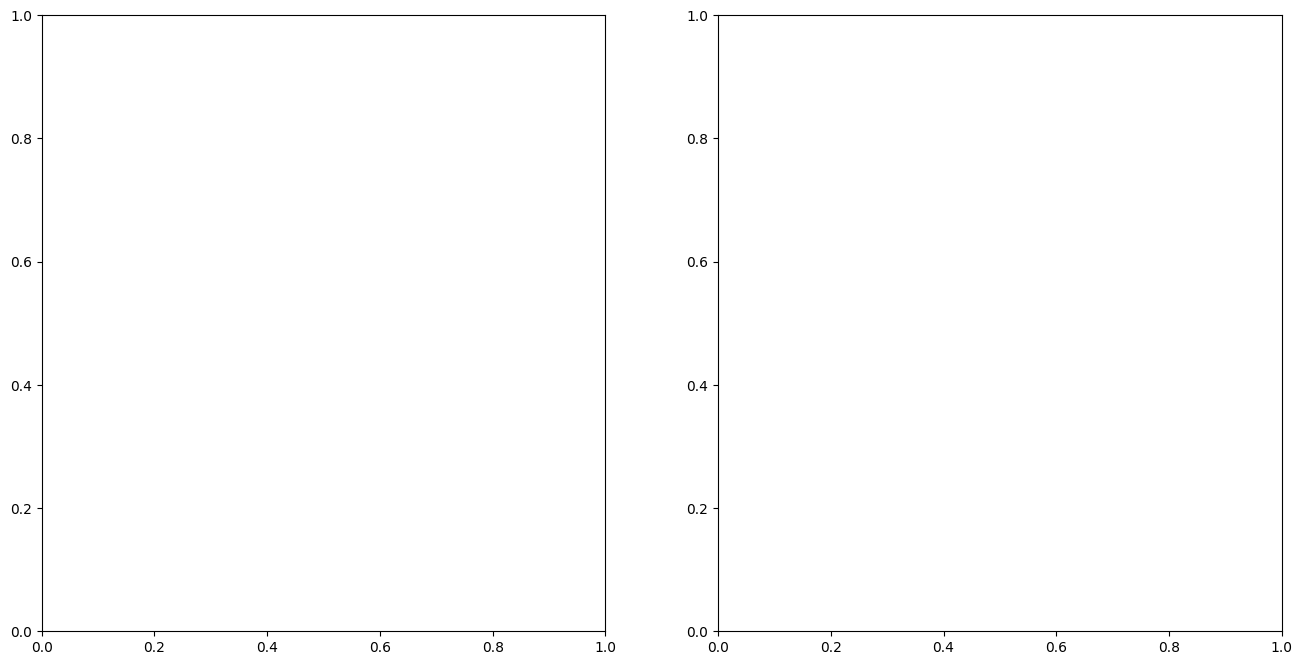

In [17]:
if RUN_BEST_TRAINED_VIZ:
    topks, hist_return_data = vizualize_network(net, projectloader, len(classes), device, run_vis_dir, args, k=10,
                                               plot_histograms=True, visualize_prototype_maps=True, plot_always_histograms=False,
                                               normalize_frequencies=False, prototype_labels=checkpoint_to_load,
                                               plot_topk=False, histogram_return_type='both', filter_outlier_prototypes=False)
    print(f"Visualization saved to {run_vis_dir}")

# Global explanation

In [61]:
from util.histograms import class_idx_to_name
from pipnet.count_pipnet import calculate_virtual_weights

def calculate_global_explanation(net, classes, custom_onehot_scale=False, use_expanded_prototypes=False):
    """
    Calculate the importance of each prototype for each class in the network.
    
    Args:
        net: The trained CountPIPNet model
        classes: List of class names
        
    Returns:
        Dictionary mapping class indices to tensors of prototype importances
    """
    # Detect if using CountPIPNet by checking for _max_count attribute
    is_count_pipnet = hasattr(net.module, '_max_count')
    num_prototypes = net.module._num_prototypes
    num_classes = net.module._num_classes

    if not is_count_pipnet or use_expanded_prototypes:
        classification_weights = net.module._classification.weight # shape [num_classes, num_prototypes] 
        global_explanation = {c: classification_weights[c, :] for c in range(num_classes)}

        return global_explanation        
    
    virtual_weights = calculate_virtual_weights(net, testloader, device,
                                                custom_onehot_scale=custom_onehot_scale) # shape [num_classes, num_prototypes]

    # Dictionary to store the importance of each prototype for each class
    class_prototype_importances = {}

    # Iterate through all prototypes
    for i in range(num_prototypes):
        # Get importance of this prototype for each class
        prototype_importance_per_class = virtual_weights[:, i]
        
        # Distribute the importance values to their respective classes
        for class_idx, class_importance in enumerate(prototype_importance_per_class):
            if class_idx not in class_prototype_importances.keys():
                class_prototype_importances[class_idx] = torch.zeros([num_prototypes], device=class_importance.device)

            class_prototype_importances[class_idx][i] += class_importance
    
    return class_prototype_importances

In [62]:
from plotly.io import write_image
from util.enums import prototype_labels as PROTOTYPE_LABELS

def show_global_explanation(net, classes, global_explanation=None, top_k_prototypes=None, output_path=None,
                            custom_onehot_scale=False, use_expanded_prototypes=False, model_name=checkpoint_to_load):
    """
    Visualize the global explanation as a heatmap using Plotly.
    
    Args:
        net: The trained CountPIPNet model
        classes: List of class names
        global_explanation: Pre-computed global explanation (optional)
        top_k_prototypes: Number of top prototypes to display per class (optional)
        output_path: Path to save the visualization (optional)
        custom_onehot_scale (bool): Flag for scaling.
        use_expanded_prototypes (bool): Flag to use expanded prototype view.
        model_name (str, optional): The name/ID of the model checkpoint. Used to fetch
                                    model-specific prototype labels for the visualization.
        
    Returns:
        Plotly figure object
    """
    import plotly.graph_objects as go
    import numpy as np
    
    # Calculate global explanation if not provided
    if global_explanation is None:
        global_explanation = calculate_global_explanation(net, classes, custom_onehot_scale=custom_onehot_scale,
                                                          use_expanded_prototypes=use_expanded_prototypes)
            
    # Convert dictionary to numpy array for heatmap
    num_classes = len(global_explanation)
    num_prototypes = net.module._num_prototypes

    if use_expanded_prototypes:
        num_prototypes *= net.module._max_count
    
    # Initialize the data matrix
    data_matrix = np.zeros((num_classes, num_prototypes))
    
    # Fill in the data matrix with importance values
    for class_idx, prototype_importances in global_explanation.items():
        data_matrix[class_idx] = prototype_importances.cpu().numpy()
    
    # Optionally filter to show only the top-k most important prototypes per class
    if top_k_prototypes is not None:
        top_k_mask = np.zeros_like(data_matrix, dtype=bool)
        for class_idx in range(num_classes):
            top_indices = np.argsort(data_matrix[class_idx])[-top_k_prototypes:]
            top_k_mask[class_idx, top_indices] = True
        filtered_data = np.where(top_k_mask, data_matrix, np.nan)
    else:
        filtered_data = data_matrix
    
    # Create x and y labels
    class_labels = [class_idx_to_name(i) for i in range(num_classes)]
    
    short_x_labels = None
    if not use_expanded_prototypes:
        prototype_labels = [f"Prototype {i}" for i in range(num_prototypes)]
    else:
        prototype_idx = [(i // net.module._max_count, i % net.module._max_count) for i in range(num_prototypes)]
        prototype_labels = [f"Prot. {prot_id} Embed. {embed_id}" for prot_id, embed_id in prototype_idx] 
        short_x_labels = [f"{i % net.module._max_count + 1}" for i in range(num_prototypes)]

    # Define desired order for classes
    desired_order = [
        "1 Circle", "2 Circles", "3 Circles", "1 Triangle", "2 Triangles", "3 Triangles",
        "1 Square", "2 Squares", "3 Squares", "1 Hexagon", "2 Hexagons", "3 Hexagons"
    ]
    
    # Reorder data matrix and labels according to desired order
    reordered_data = filtered_data.copy()
    reordered_labels = class_labels.copy()
    
    order_mapping = {label: i for i, label in enumerate(desired_order)}
    sorted_indices = sorted(range(len(class_labels)), 
                           key=lambda i: order_mapping.get(class_labels[i], len(desired_order) + i))
    if len(order_mapping) > 0:
        reordered_data = filtered_data[sorted_indices]
        reordered_labels = [class_labels[i] for i in sorted_indices]
    
    fig = go.Figure(data=go.Heatmap(
        z=reordered_data,
        x=prototype_labels,
        y=reordered_labels,
        colorscale='Plasma',
        hoverongaps=False,
        colorbar=dict(title="Importance", titleside="right"),
        hovertemplate='Class: %{y}<br>%{x}<br>Importance: %{z:.3f}<extra></extra>'
    ))
    
    # Prepare axis configurations
    xaxis_config = dict(title="Prototypes", tickangle=-45)
    
    if use_expanded_prototypes:
        num_base_prototypes = net.module._num_prototypes
        max_count = net.module._max_count
        
        xaxis_config.update({
            "title": "Count",
            "tickvals": prototype_labels,
            "ticktext": short_x_labels,
            "range": [-0.5, num_prototypes - 0.5],
            'tickangle': 0
        })

        # ---- MODIFICATION START: Load model-specific labels ----
        # Create a mapping from prototype ID to its custom label, if available
        top_labels = {}
        if model_name and model_name in PROTOTYPE_LABELS:
            print(f"✅ Found model-specific labels for '{model_name}'. Applying to plot.")
            label_data = PROTOTYPE_LABELS[model_name]
            top_labels = {item['prototype']: item['label'] for item in label_data}
        else:
            if model_name:
                print(f"⚠️ Could not find labels for '{model_name}'. Using generic labels.")
        # ---- MODIFICATION END ----
        
        # Add visual separators and group labels
        for prot_id in range(num_base_prototypes):
            if prot_id < num_base_prototypes - 1:
                line_position = (prot_id + 1) * max_count - 0.5
                fig.add_shape(
                    type='line', xref='x', yref='y',
                    x0=line_position, y0=-0.5,
                    x1=line_position, y1=num_classes - 0.5,
                    line=dict(color='dodgerblue', width=2, dash='dash')
                )
            
            center_position = prot_id * max_count + (max_count - 1) / 2.0

            # ---- MODIFICATION START: Use custom labels for annotations ----
            # Get the custom label if it exists, otherwise fall back to the generic "Proto #" label
            label_text = top_labels.get(prot_id, f"Proto #{prot_id}")
            
            fig.add_annotation(
                x=center_position, y=1.05,
                xref='x', yref='paper',
                text=f"<b>{label_text}</b>", # Use the determined label
                showarrow=False,
                font=dict(size=10, color="black"), 
                xanchor='center'
            )
            # ---- MODIFICATION END ----
    
    # Update layout for better readability
    fig.update_layout(
        xaxis=xaxis_config,
        yaxis=dict(title="Classes"),
        width=max(800, num_prototypes * 25),
        height=max(600, num_classes * 30),
        margin=dict(l=150, r=50, t=120, b=150)
    )
    
    if output_path:
        # Create directory if it doesn't exist
        output_path.mkdir(parents=True, exist_ok=True)
        fig.write_html(output_path / 'global_explanation.html')
        try:
            # Using kaleido engine which is the modern successor to orca
            fig.write_image(output_path / 'global_explanation.pdf',
                           engine='orca')
            fig.write_image(output_path / 'global_explanation.png', scale=3,
                           engine='orca')
            print(f"Saved global explanation visualization to {output_path}")
        except Exception as e:
            print(f"Could not save static images.")

    return fig

In [65]:
1.15/1.157

0.9939498703543647

Saved global explanation visualization to C:\Edu\Mech_Interp\PIPNet\visualizations\20250407_021157_15_pipnet_s21_stage7_p16\trained_best


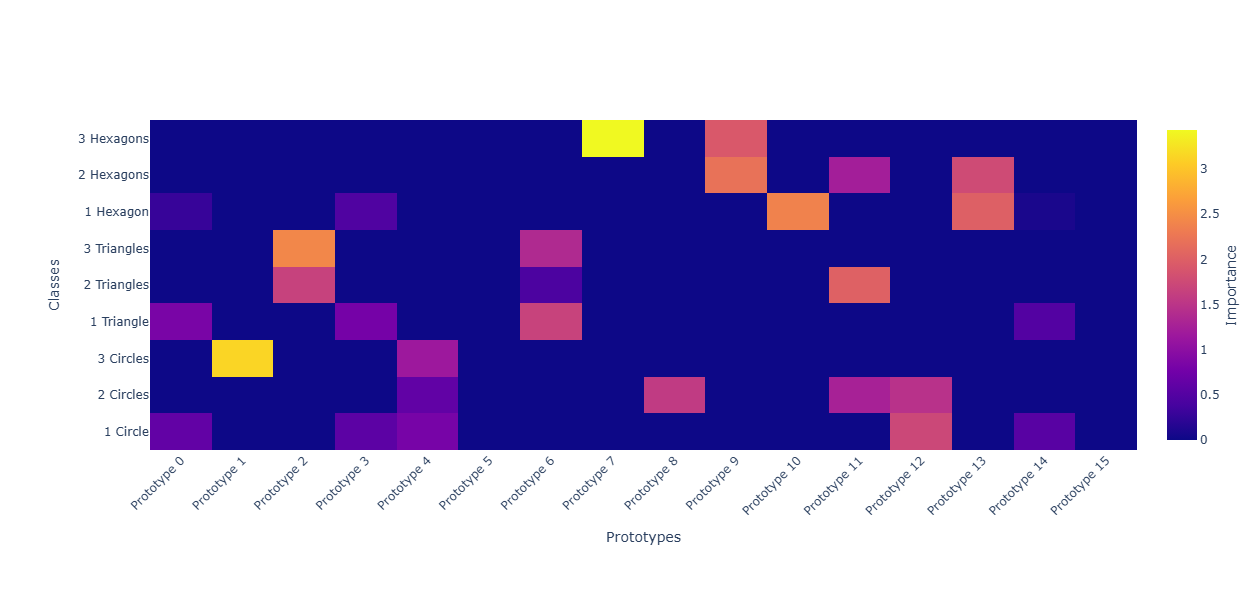

In [63]:
show_global_explanation(net, classes, output_path=run_vis_dir)

In [52]:
# show_global_explanation(net, classes, output_path=run_vis_dir, custom_onehot_scale=True)

✅ Found model-specific labels for '20250706_032740_5_final_s21_stage7_p16_onehot_current_grad_train'. Applying to plot.
Saved global explanation visualization to C:\Edu\Mech_Interp\PIPNet\visualizations\20250706_032740_5_final_s21_stage7_p16_onehot_current_grad_train\trained_best


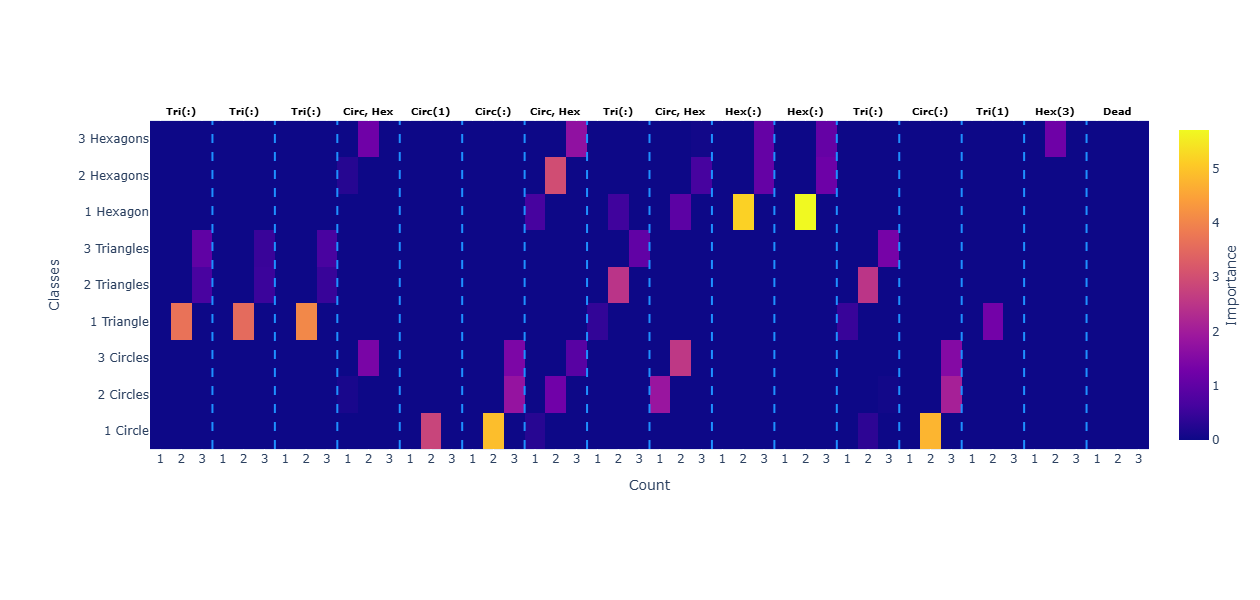

In [55]:
show_global_explanation(net, classes, output_path=run_vis_dir, use_expanded_prototypes=True)

## Activation-based and weight-based importance scores agreement 

In [124]:
weight_based_importance_scores = calculate_global_explanation(net, classes)
weight_based_importance_scores

{0: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.6539,
         0.0000, 0.0000, 0.0000, 3.6174, 1.8117, 0.0000, 0.0000],
        device='cuda:0'),
 1: tensor([0.0000, 0.0000, 0.0000, 0.0000, 3.2612, 0.0000, 0.0000, 0.0000, 0.0000,
         1.7256, 0.3782, 0.0000, 0.0000, 0.0000, 1.0479, 0.0000],
        device='cuda:0'),
 2: tensor([0.0000, 1.3368, 2.2175, 0.0000, 0.0000, 2.7634, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.7213, 0.0000, 0.0000, 0.0000, 0.0000],
        device='cuda:0'),
 3: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 2.6416, 0.0000, 0.0000, 0.0000],
        device='cuda:0'),
 4: tensor([0.0000, 0.0000, 0.0000, 0.0000, 2.6153, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        device='cuda:0'),
 5: tensor([0.0000, 0.5766, 2.0296, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0

In [125]:
import numpy as np

# --- Transform both importance metrics to a uniform format ---
# The target format is: {prototype_idx: np.array_of_scores_for_all_classes}

# Get model and data dimensions, which are already available
num_classes = len(classes)
num_prototypes = net.module._num_prototypes

# 1. Transform weight-based scores
transformed_weight_scores = {}
for p_idx in range(num_prototypes):
    class_importances = np.zeros(num_classes)
    for c_idx in range(num_classes):
        if c_idx in weight_based_importance_scores:
            class_importances[c_idx] = weight_based_importance_scores[c_idx][p_idx].item()
    transformed_weight_scores[p_idx] = class_importances

In [126]:
mean_prototype_value_per_class, non_zero_counts_per_class = hist_return_data

# Transform all the scores to 0-1 range
# Mean scores
transformed_mean_scores = {prot_idx: np.array(scores_list) for (prot_idx, scores_list) in mean_prototype_value_per_class.items()}

# Non-zero counts
MAX_COUNT = 400
NORMALIZE_COUNT = True

transformed_count_scores = {}
for p_idx in range(num_prototypes):
	class_counts = np.zeros(num_classes)
	if p_idx in non_zero_counts_per_class:
		proto_class_counts = non_zero_counts_per_class[p_idx]
		for c_idx in range(num_classes):
			class_counts[c_idx] = proto_class_counts.get(c_idx, 0)
	transformed_count_scores[p_idx] = class_counts
	if NORMALIZE_COUNT:
		transformed_count_scores[p_idx] /= MAX_COUNT

In [127]:
# --- Display the results to verify the new uniform format ---
print("--- Transformed Weight-Based Importance (Uniform View) ---")
print("Format: {prototype_idx: np.array([class0_imp, class1_imp, ...])}\n")
for i in range(min(22, num_prototypes)):
    print(f"{i}: {np.round(transformed_weight_scores[i], 2)}")

print("\n\n--- Transformed Mean-Activation-Based Importance (Uniform View) ---")
print("Format: {prototype_idx: np.array([class0_count, class1_count, ...])}\n")
for i in range(min(22, num_prototypes)): # Print first 3 prototypes for verification
    print(f"{i}: {np.round(transformed_mean_scores[i], 2)}")

print("\n\n--- Transformed Count-Based Importance (Uniform View) ---")
print("Format: {prototype_idx: np.array([class0_count, class1_count, ...])}\n")
for i in range(min(22, num_prototypes)): # Print first 3 prototypes for verification
    print(f"{i}: {np.round(transformed_count_scores[i], 2)}")    

--- Transformed Weight-Based Importance (Uniform View) ---
Format: {prototype_idx: np.array([class0_imp, class1_imp, ...])}

0: [ 0.    0.    0.    0.    0.    0.   10.46  0.    0.  ]
1: [0.   0.   1.34 0.   0.   0.58 0.   0.   0.  ]
2: [0.   0.   2.22 0.   0.   2.03 0.   0.   0.  ]
3: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
4: [0.   3.26 0.   0.   2.62 0.   0.   0.   0.  ]
5: [0.   0.   2.76 0.   0.   0.   0.   0.   0.  ]
6: [ 0.    0.    0.    0.    0.    0.    0.    0.   10.57]
7: [0.   0.   0.   0.   0.   0.   0.   9.87 0.  ]
8: [1.65 0.   0.   0.   0.   0.   0.   0.   0.  ]
9: [0.   1.73 0.   0.   0.   0.   0.   0.   0.  ]
10: [0.   0.38 0.   0.   0.   0.   0.   0.   0.  ]
11: [0.   0.   0.72 0.   0.   0.   0.   0.   0.  ]
12: [3.62 0.   0.   2.64 0.   0.   0.   0.   0.  ]
13: [1.81 0.   0.   0.   0.   0.   0.   0.   0.  ]
14: [0.   1.05 0.   0.   0.   0.   0.   0.   0.  ]
15: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


--- Transformed Mean-Activation-Based Importance (Uniform View) ---
Format: {prototyp

In [128]:
transformed_mean_scores

{0: array([0.00e+00, 0.00e+00, 0.00e+00, 2.50e-03, 0.00e+00, 0.00e+00,
        2.99e+00, 0.00e+00, 0.00e+00], dtype=float32),
 1: array([0.0e+00, 0.0e+00, 0.0e+00, 2.5e-03, 0.0e+00, 3.0e+00, 0.0e+00,
        0.0e+00, 3.0e+00], dtype=float32),
 2: array([0.    , 0.    , 0.    , 0.    , 0.    , 2.9975, 0.    , 0.    ,
        2.885 ], dtype=float32),
 3: array([2.5000e-03, 0.0000e+00, 2.7375e+00, 0.0000e+00, 0.0000e+00,
        2.2325e+00, 0.0000e+00, 0.0000e+00, 1.6950e+00], dtype=float32),
 4: array([0.00e+00, 2.50e-03, 0.00e+00, 5.00e-03, 3.00e+00, 2.50e-03,
        0.00e+00, 2.84e+00, 0.00e+00], dtype=float32),
 5: array([0.0e+00, 0.0e+00, 3.0e+00, 2.5e-03, 0.0e+00, 3.0e+00, 0.0e+00,
        0.0e+00, 3.0e+00], dtype=float32),
 6: array([0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 2.5e-03, 0.0e+00,
        0.0e+00, 3.0e+00], dtype=float32),
 7: array([0.    , 0.    , 0.    , 0.    , 0.005 , 0.    , 0.    , 2.9925,
        0.    ], dtype=float32),
 8: array([3.0000e+00, 0.0000e+00, 2.

In [129]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


def plot_importance_comparison(
    importance_scores_x: dict,
    importance_scores_y: dict,
    class_idx_to_name: callable,
    figure_title: str = "Activation vs. Weight-Based Importance per Class",
    x_label: str = "Activation Score",
    y_label: str = "Weight Score",
    grid_shape: tuple = (3, 3),
    height: int = 800,
    width: int = 900,
    template: str = 'plotly_white',
    special_prototypes: list = None,
    special_label: str = None,
    special_symbol: str = 'diamond',
    exclude_special_prototypes_from_corr_calc: bool = False
):
    num_prototypes = len(importance_scores_x)
    first_key = next(iter(importance_scores_x))
    num_classes = importance_scores_x[first_key].shape[0]
    rows, cols = grid_shape
    if rows * cols < num_classes:
        raise ValueError(f"Grid shape {grid_shape} too small for {num_classes} classes")

    special_set = set(special_prototypes) if special_prototypes else set()
    subplot_titles = [class_idx_to_name(c) for c in range(num_classes)]

    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=subplot_titles,
        shared_xaxes=True,
        shared_yaxes=True,
        vertical_spacing=0.15
    )

    for c_idx in range(num_classes):
        x_data = []
        y_data = []
        hover_text = []
        symbols = []

        for p in range(num_prototypes):
            x_val = importance_scores_x[p][c_idx]
            y_val = importance_scores_y[p][c_idx]
            x_data.append(x_val)
            y_data.append(y_val)

            text = f"Prototype {p}"
            if p in special_set and special_label:
                text += f"<br>{special_label}"
                symbols.append(special_symbol)
            else:
                symbols.append('circle')
            hover_text.append(text)

        # Apply mask for correlation calculation
        corr_mask = [p not in special_set for p in range(num_prototypes)] if exclude_special_prototypes_from_corr_calc else [True] * num_prototypes
        corr_x = np.array(x_data)[corr_mask]
        corr_y = np.array(y_data)[corr_mask]
        corr = np.corrcoef(corr_x, corr_y)[0, 1] if len(corr_x) > 1 else np.nan

        trace = go.Scatter(
            x=x_data,
            y=y_data,
            mode='markers',
            marker=dict(size=8, opacity=0.8, symbol=symbols),
            hovertext=hover_text,
            name=f'Class {c_idx}'
        )

        row = (c_idx // cols) + 1
        col = (c_idx % cols) + 1
        fig.add_trace(trace, row=row, col=col)
        fig.layout.annotations[c_idx].text += f'<br><i>r = {corr:.3f}</i>'

    # Add special prototype legend entry
    if special_prototypes and special_label:
        fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(symbol=special_symbol, size=10, color='black'),
            name=special_label
        ))

    fig.update_layout(
        title_text=f"<b>{figure_title}</b>",
        title_x=0.5,
        height=height,
        width=width,
        showlegend=False,
        template=template
    )
    fig.update_xaxes(title_text=x_label)
    fig.update_yaxes(title_text=y_label)
    fig.show()

## Plotting utility

In [130]:
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio

def plot_combined_importance(
    importance_scores_x: dict,
    importance_scores_y: dict,
    class_idx_to_name: callable,
    figure_title: str = "Overall Activation vs. Weight-Based Importance",
    x_label: str = "Activation Score",
    y_label: str = "Weight Score",
    color_palette: list = None,
    marker_size: int = 10,
    marker_opacity: float = 0.7,
    marker_line_width: int = 1,
    marker_line_color: str = 'DarkSlateGrey',
    height: int = 600,
    width: int = 800,
    template: str = 'plotly_white',
    special_prototypes: list = None,
    special_label: str = None,
    special_symbol: str = 'diamond',
    exclude_special_prototypes_from_corr_calc: bool = False,
    show_prototype_labels: bool = True,            # ← new
    label_distance_threshold: float = 0.01,           # ← new (2% default)
    save_path="my_plot.pdf",
    plot_title=True,
    plot_prefix='PIP-Net model',
):
    num_prototypes = len(importance_scores_x)
    first_key = next(iter(importance_scores_x))
    num_classes = importance_scores_x[first_key].shape[0]

    if color_palette is None:
        color_palette = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
        ]

    special_set = set(special_prototypes) if special_prototypes else set()

    fig = go.Figure()
    all_x, all_y = [], []

    for c_idx in range(num_classes):
        x_data, y_data = [], []
        hover_text, symbols = [], []

        for p in range(num_prototypes):
            x = importance_scores_x[p][c_idx]
            y = importance_scores_y[p][c_idx]
            x_data.append(x)
            y_data.append(y)
            all_x.append(x); all_y.append(y)

            txt = f"Prototype {p}<br>Class: {class_idx_to_name(c_idx)}"
            if p in special_set and special_label:
                txt += f"<br>{special_label}"
                symbols.append(special_symbol)
            else:
                symbols.append('circle')
            hover_text.append(txt)

        # main scatter
        fig.add_trace(go.Scatter(
            x=x_data,
            y=y_data,
            mode='markers',
            name=class_idx_to_name(c_idx),
            marker=dict(
                color=color_palette[c_idx % len(color_palette)],
                size=marker_size,
                opacity=marker_opacity,
                symbol=symbols,
                line=dict(width=marker_line_width, color=marker_line_color)
            ),
            hovertext=hover_text
        ))

        # optional labels
        if show_prototype_labels:
            xs = np.array(x_data)
            ys = np.array(y_data)
            # normalize per-class
            xr = xs.max() - xs.min() or 1.0
            yr = ys.max() - ys.min() or 1.0
            x_norm = (xs - xs.min()) / xr
            y_norm = (ys - ys.min()) / yr

            label_x, label_y, label_text = [], [], []
            for i in range(len(xs)):
                # compute min distance to any other point
                dx = x_norm - x_norm[i]
                dy = y_norm - y_norm[i]
                dist = np.hypot(dx, dy)
                dist[i] = np.inf
                if dist.min() > label_distance_threshold:
                    label_x.append(xs[i])
                    label_y.append(ys[i])
                    label_text.append(str(i))

            # plot only the isolated labels
            if label_x:
                # shift labels up by a tiny fraction of y-range
                y_offset = 0.025 * yr
                fig.add_trace(go.Scatter(
                    x=label_x,
                    y=[y + y_offset for y in label_y],
                    mode='text',
                    text=label_text,
                    textposition="top center",
                    textfont=dict(size=9, color='rgba(0,0,0,0.5)'),
                    showlegend=False,
                    hoverinfo='skip'
                ))
                
    # Add special prototype legend entry
    if special_prototypes and special_label:
        fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(symbol=special_symbol, size=10, color='black'),
            name=special_label
        ))

    # overall correlation
    if exclude_special_prototypes_from_corr_calc:
        mask = [(i % num_prototypes) not in special_set for i in range(len(all_x))]
    else:
        mask = [True] * len(all_x)
    corr_x = np.array(all_x)[mask]
    corr_y = np.array(all_y)[mask]
    overall_corr = np.corrcoef(corr_x, corr_y)[0, 1] if len(corr_x) > 1 else np.nan

    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        height=height,
        width=width,
        legend_title="Classes",
        template=template
    )

    if plot_title:
         fig.update_layout(
            title=(
                f"<b>{figure_title}</b><br>"
                f"<i>{plot_prefix}; Overall correlation: r = {overall_corr:.3f}</i>"
            ),
            title_x=0.5,)
    fig.show()
    # Optional: save high-resolution static image
    if save_path := locals().get("save_path"):
        ext = save_path.split('.')[-1].lower()
        if ext in {"png", "jpg"}:
            pio.write_image(fig, save_path, format=ext, engine='orca',
                            scale=4, width=width, height=height)
        elif ext in {"pdf", "svg"}:
            pio.write_image(fig, save_path, format=ext, engine='orca',
                            width=width, height=height)
        else:
            raise ValueError(f"Unsupported file format for save_path: {save_path}")

## Non-zero count comparison vs Mean scores

In [131]:
DEAD_PROTOTYPES = [3, 15] # 3, 15

In [132]:
plot_importance_comparison(
    transformed_mean_scores, 
    transformed_count_scores, 
    class_idx_to_name,
    figure_title="Mean Activation vs. Non-zero counts",
    x_label="Mean Activation",
    y_label="Non-zero counts",
    special_prototypes=DEAD_PROTOTYPES,
    exclude_special_prototypes_from_corr_calc=True
)

In [133]:
plot_combined_importance(
    transformed_mean_scores, 
    transformed_count_scores, 
    class_idx_to_name,
    figure_title="Mean Activation vs. Non-zero counts",
    x_label="Mean Activation",
    y_label="Non-zero counts",
    special_prototypes=DEAD_PROTOTYPES,
    exclude_special_prototypes_from_corr_calc=True
)

## Weight scores vs Mean scores

### Individual prototypes plot

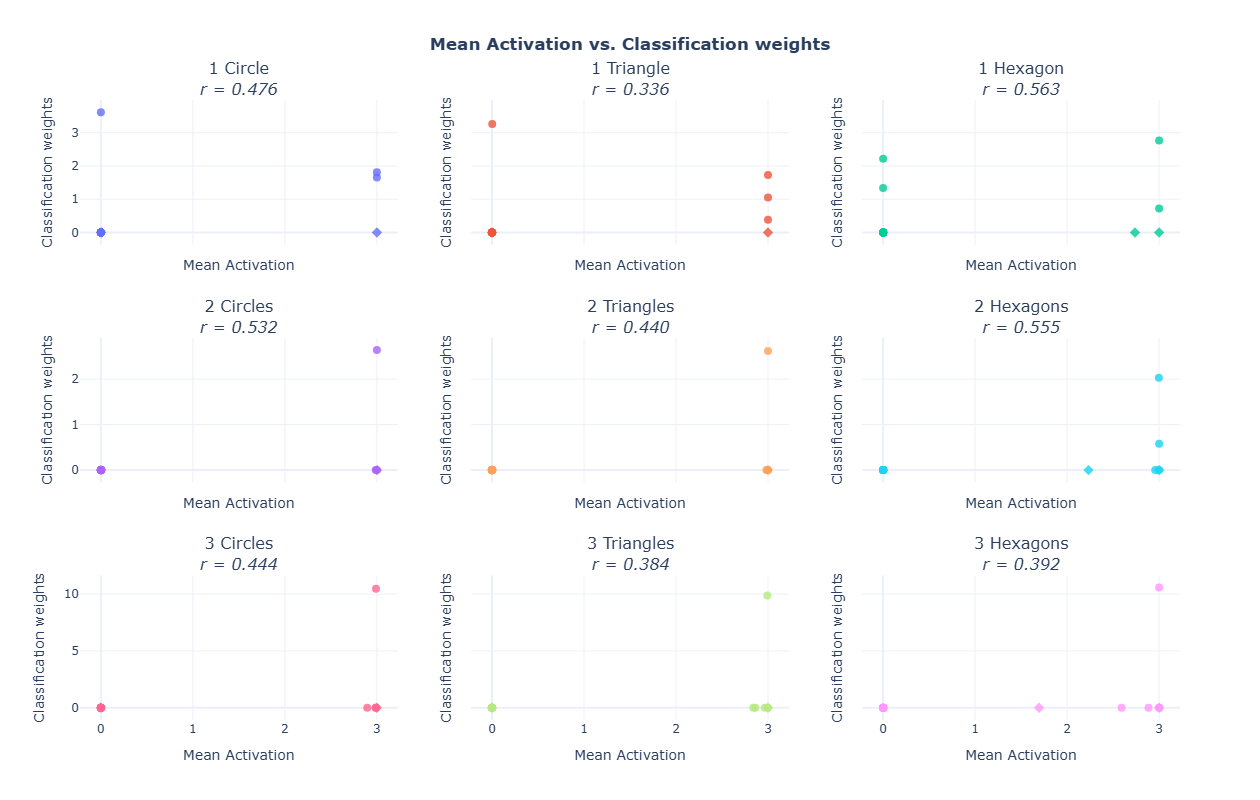

In [134]:
plot_importance_comparison(
    transformed_mean_scores, 
    transformed_weight_scores, 
    class_idx_to_name,
    figure_title="Mean Activation vs. Classification weights",
    x_label="Mean Activation",
    y_label="Classification weights",
    special_prototypes=DEAD_PROTOTYPES,
    special_label='Dead',
    exclude_special_prototypes_from_corr_calc=True
)

### Global plot

In [135]:
plot_combined_importance(
    transformed_mean_scores, 
    transformed_weight_scores, 
    class_idx_to_name,
    figure_title="Mean Activation vs. Classification weights",
    x_label="Mean Activation",
    y_label="Classification weights",
    special_prototypes=DEAD_PROTOTYPES,
    special_label='Dead',
    exclude_special_prototypes_from_corr_calc=True,
    save_path='countpipnet_linear_combined_importance_plot.pdf',
    plot_title=True,
    plot_prefix='CountPIPNet: Linear Embedding model',
    label_distance_threshold=0.02
)

### Expanded activations plot

In [112]:
from pipnet.count_pipnet import estimate_mean_intermediate_features

n_proto = net.module._num_prototypes
n_classes = net.module._num_classes

mean_expanded_act, all_class_labels = estimate_mean_intermediate_features(net, testloader, device, return_full_data=True)
mean_expanded_act.shape, all_class_labels.shape

all_clamped_counts.shape:  torch.Size([900, 16])
all_class_labels.shape:  torch.Size([900])
intermediate_features.shape:  torch.Size([900, 48])


(torch.Size([900, 48]), torch.Size([900]))

In [113]:
transformed_expanded_act = {p: torch.zeros([n_classes]) for p in range(mean_expanded_act.shape[1])}
near_zero_threshold: float = 0.01

for p in transformed_expanded_act.keys():
    for cls in all_class_labels.unique():
        current_activations = mean_expanded_act[:, p]
        class_mask = (all_class_labels == cls)
        num_class_samples = int(torch.sum(class_mask))
        
        if num_class_samples > 0:
            transformed_expanded_act[p][cls] = torch.mean(current_activations[class_mask])
        else:
            transformed_expanded_act[p][cls] = 0.0

    transformed_expanded_act[p] = transformed_expanded_act[p].numpy()

transformed_expanded_act    

{0: array([0.  , 0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       dtype=float32),
 1: array([0.  , 0.75, 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  ],
       dtype=float32),
 2: array([0.        , 0.12      , 0.        , 0.        , 0.97999996,
        0.        , 0.        , 1.        , 0.        ], dtype=float32),
 3: array([0.  , 0.14, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       dtype=float32),
 4: array([0.  , 0.77, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       dtype=float32),
 5: array([0.  , 0.09, 0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 0.  ],
       dtype=float32),
 6: array([0.01, 0.24, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01],
       dtype=float32),
 7: array([0.  , 0.68, 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  ],
       dtype=float32),
 8: array([0.  , 0.08, 0.  , 0.  , 0.96, 0.  , 0.  , 1.  , 0.  ],
       dtype=float32),
 9: array([0.02      , 0.        , 0.04      , 0.44      , 0.        ,
        0.38      , 0.39      , 0.        , 0.45999998], dtype=float32),


In [114]:
expanded_weights = net.module._classification.weight #[n_classes, n_proto]

transformed_expanded_weights = {p: expanded_weights[:, p].cpu().numpy() for p in range(mean_expanded_act.shape[1])}
transformed_expanded_weights

{0: array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 1: array([0.       , 3.6842823, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ], dtype=float32),
 2: array([0.        , 0.        , 0.        , 0.        , 0.68206483,
        0.        , 0.        , 1.0143301 , 0.        ], dtype=float32),
 3: array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 4: array([0.       , 3.5485187, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ], dtype=float32),
 5: array([0.        , 0.        , 0.        , 0.        , 0.51608974,
        0.        , 0.        , 0.48416048, 0.        ], dtype=float32),
 6: array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 7: array([0.       , 4.0540795, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ], dtype=float32),
 8: array([0.        , 0.        , 0.        , 0.        , 0.47728142,
        0.        , 0.        , 0.68249047, 

In [115]:
plot_combined_importance(
    transformed_expanded_act, 
    transformed_expanded_weights, 
    class_idx_to_name,
    figure_title="Mean Expanded Activation vs. Expanded weights",
    x_label="Mean Activation",
    y_label="Classification weights",
    # special_prototypes=DEAD_PROTOTYPES,
    # special_label='Dead',
    # exclude_special_prototypes_from_corr_calc=True,
    # save_path='pipnet_combined_importance_plot.pdf',
    plot_title=True,
    plot_prefix='PIP-Net model',
    label_distance_threshold=0.02
)

## Model specific explanation:

In [56]:
from util.enums import prototype_labels as PROTOTYPE_LABELS
import re

def get_prototype_groups(num_prototypes_total=16, prototype_labels=None, model_name=None):
    if prototype_labels is None:
        assert model_name is not None, "Must provide model_name if prototype_labels is not given"
        prototype_labels = PROTOTYPE_LABELS[model_name]

        print("🤖 Deducing prototype groups automatically...")

        # Initialize groups, including the new 'poly' group
        shape_only_group = []
        count_only_group = []
        poly_group = []  # NEW
        mixed_group = []
        unique_group = []

        # Parse labels to categorize each prototype based on defined rules
        for item in prototype_labels:
            idx = item["prototype"]
            label = item["label"]

            # Rule 1: 'Dead' prototypes are ignored here
            if "Dead" in label:
                continue

            # Rule 2: Count-only prototypes, e.g., "Count-1"
            elif label.startswith("Count"):
                count_only_group.append(idx)
            
            # Rule 3: NEW "Poly" group for multiple shapes, e.g., "Circ, Hex"
            # This is identified by a comma in the label WITHOUT parentheses.
            elif ',' in label and '(' not in label:
                poly_group.append(idx)

            # Rule 4: Shape-only prototypes, e.g., "Circ(:)"
            elif "(:)" in label:
                shape_only_group.append(idx)

            # Rule 5 & 6: Shape-specific prototypes (unique or mixed count)
            else:
                match = re.search(r'\((.*?)\)', label)
                if match:
                    content = match.group(1).strip()
                    if ',' in content: # Comma *inside* parentheses
                        mixed_group.append(idx)
                    else: # No comma inside parentheses
                        unique_group.append(idx)
                else:
                    print(f"⚠️ Warning: Label '{label}' for prototype {idx} has an unrecognized format. Treating as unique.")
                    unique_group.append(idx)

        print("Deduction complete:")
        print(f"  Shape-only: {sorted(shape_only_group)}")
        print(f"  Count-only: {sorted(count_only_group)}")
        print(f"  Poly:       {sorted(poly_group)}")
        print(f"  Mixed:      {sorted(mixed_group)}")
        print(f"  Unique:     {sorted(unique_group)}")

    # Define group → color mapping, adding 'poly'
    group_to_color = {
        "count": "red",
        "shape": "deepskyblue",
        "poly": "darkviolet",  # NEW (purple-ish color)
        "mixed": "rgb(0, 100, 0)",
        "unique": "rgb(255, 207, 0)",
        "dead": "gray"
    }

    # Define group → order priority, adding 'poly' and shifting others
    group_to_priority = {
        "shape": 1,
        "count": 2,
        "poly": 3,      # NEW
        "mixed": 4,     # was 3
        "unique": 5,    # was 4
        "dead": 6       # was 5
    }

    # Step 1: Concatenate all dynamically found groups
    all_grouped = shape_only_group + count_only_group + poly_group + mixed_group + unique_group

    # Step 2: Check for overlaps (sanity check)
    seen = set()
    duplicates = set()
    for idx in all_grouped:
        if idx in seen:
            duplicates.add(idx)
        else:
            seen.add(idx)

    if duplicates:
        print("⚠️ Warning: Duplicate prototype indices found in different groups:", sorted(duplicates))
    else:
        print("✅ No overlaps found in group assignments.")

    # Step 3: Check for dead or unassigned prototypes
    dead_group = []
    for i in range(num_prototypes_total):
        if i not in seen:
            dead_group.append(i)

    if not dead_group:
        print("✅ No dead/unassigned prototypes.")
    else:
        print(f"ℹ️ Found {len(dead_group)} dead/unassigned prototypes: {dead_group}")

    # Step 4: Reverse mapping from index to group, adding 'poly'
    index_to_group = {}
    for i in shape_only_group:
        index_to_group[i] = "shape"
    for i in count_only_group:
        index_to_group[i] = "count"
    for i in poly_group:
        index_to_group[i] = "poly"
    for i in mixed_group:
        index_to_group[i] = "mixed"
    for i in unique_group:
        index_to_group[i] = "unique"

    # Step 5: Build label map
    if prototype_labels is None:
        assert model_name is not None
        prototype_labels = PROTOTYPE_LABELS[model_name]
    label_map = {d["prototype"]: d["label"] for d in prototype_labels}

    # Step 6: Construct final list of definitions
    prototype_group_definitions = []
    for i in range(num_prototypes_total):
        group = index_to_group.get(i, "dead")
        entry = {
            "prototype": [i],
            "group_name": group,
            "color": group_to_color[group],
            "label": label_map.get(i, "Dead/Unassigned"),
            "order_priority": group_to_priority[group]
        }
        prototype_group_definitions.append(entry)

    return prototype_group_definitions

In [57]:
from plotly.io import write_image
import plotly.graph_objects as go
import numpy as np

def show_global_explanation(net, classes, global_explanation=None, top_k_prototypes=None, output_path=None, 
                            order_prototypes_by_group=True, model_name=checkpoint_to_load): # New parameter
    """
    Visualize the global explanation as a heatmap using Plotly.
    Optionally orders prototypes on x-axis by group and adds counts to legend.
    """
        
    num_classes = len(classes)
    num_prototypes_total = net.module._num_prototypes
    
    prototype_group_definitions = get_prototype_groups(num_prototypes_total, model_name=model_name)

    if global_explanation is None:
        global_explanation = calculate_global_explanation(net, classes)

    # --- PREPARE DATA AND LABELS (ORDERING LOGIC MOVED HERE) ---
    original_data_matrix = np.zeros((num_classes, num_prototypes_total))
    for class_idx in range(num_classes):
        if class_idx in global_explanation:
            importances_tensor = global_explanation[class_idx].cpu()
            if len(importances_tensor) == num_prototypes_total:
                original_data_matrix[class_idx] = importances_tensor.numpy()
            else:
                current_len = len(importances_tensor)
                if current_len < num_prototypes_total:
                    padded = np.pad(importances_tensor.numpy(), (0, num_prototypes_total - current_len), 'constant')
                    original_data_matrix[class_idx] = padded
                else:
                    original_data_matrix[class_idx] = importances_tensor.numpy()[:num_prototypes_total]

    x_tick_labels = [f"P{i}" for i in range(num_prototypes_total)]
    x_tick_colors = ["black"] * num_prototypes_total
    x_values_for_heatmap = list(range(num_prototypes_total))
    heatmap_data_to_plot = original_data_matrix.copy() # Start with original order

    # Map original prototype index to its group info for consistent coloring/labeling
    prototype_original_idx_to_group_info = {}
    for group_def in prototype_group_definitions:
        for p_idx in group_def["prototype"]:
            if 0 <= p_idx < num_prototypes_total:
                prototype_original_idx_to_group_info[p_idx] = group_def
    
    # Apply default "Other" to any unassigned prototypes for consistent x-tick coloring
    other_group_info_default = next((g for g in prototype_group_definitions if g["group_name"] == "Other"), 
                                    {"label": "Other", "color": "grey", "group_name": "Other"})

    for i in range(num_prototypes_total):
        if i in prototype_original_idx_to_group_info:
            group_info = prototype_original_idx_to_group_info[i]
            # Use the specific label from its definition if ordering is off, or for hover
            # If ordering is on, x_tick_labels will be overwritten by ordered labels
            x_tick_labels[i] = group_info["label"] if not order_prototypes_by_group else f"P{i}" # Default if ordered
            x_tick_colors[i] = group_info["color"]
        else: # Prototype not in any definition
            x_tick_labels[i] = f"P{i}"
            x_tick_colors[i] = other_group_info_default["color"]


    ordered_prototype_display_info_list = [] # For x-axis if ordered, and for hover
    if order_prototypes_by_group:
        prototypes_in_defined_groups = set()
        # Sort group definitions by order_priority, then by first prototype index
        sorted_group_definitions_for_ordering = sorted(prototype_group_definitions, key=lambda x: (x["order_priority"], x["prototype"][0] if x["prototype"] else float('inf')))

        for group_def in sorted_group_definitions_for_ordering:
            sorted_prototypes_in_group = sorted(group_def["prototype"])
            for p_original_idx in sorted_prototypes_in_group:
                if 0 <= p_original_idx < num_prototypes_total:
                    ordered_prototype_display_info_list.append({
                        "original_idx": p_original_idx,
                        "display_label": group_def["label"], # This will be the x-tick label
                        "color": group_def["color"],
                        "group_name": group_def["group_name"]
                    })
                    prototypes_in_defined_groups.add(p_original_idx)
        
        for p_original_idx in range(num_prototypes_total):
            if p_original_idx not in prototypes_in_defined_groups:
                ordered_prototype_display_info_list.append({
                    "original_idx": p_original_idx,
                    "display_label": f"P{p_original_idx}",
                    "color": other_group_info_default["color"],
                    "group_name": other_group_info_default["group_name"]
                })
        
        # Reorder heatmap_data_to_plot based on ordered_prototype_display_info_list
        temp_heatmap_data = np.zeros((num_classes, len(ordered_prototype_display_info_list)))
        for new_idx, info in enumerate(ordered_prototype_display_info_list):
            temp_heatmap_data[:, new_idx] = original_data_matrix[:, info["original_idx"]]
        heatmap_data_to_plot = temp_heatmap_data
        
        # Update x-axis values and labels for the ordered plot
        x_values_for_heatmap = list(range(len(ordered_prototype_display_info_list)))
        x_tick_labels = [info["display_label"] for info in ordered_prototype_display_info_list]
        x_tick_colors = [info["color"] for info in ordered_prototype_display_info_list]
    else:
        # If not ordering, create display_info_list matching original order for hover
        for i in range(num_prototypes_total):
            group_info = prototype_original_idx_to_group_info.get(i, other_group_info_default)
            ordered_prototype_display_info_list.append({
                "original_idx": i,
                "display_label": group_info.get("label", f"P{i}"), # Use group label or P_idx
                "color": group_info.get("color", "grey"),
                "group_name": group_info.get("group_name", "Other")
            })


    if top_k_prototypes is not None:
        top_k_mask = np.zeros_like(heatmap_data_to_plot, dtype=bool)
        for class_idx in range(num_classes):
            top_indices = np.argsort(heatmap_data_to_plot[class_idx])[-top_k_prototypes:]
            top_k_mask[class_idx, top_indices] = True
        filtered_heatmap_data = np.where(top_k_mask, heatmap_data_to_plot, np.nan)
    else:
        filtered_heatmap_data = heatmap_data_to_plot
    
    # Y-axis (class) reordering
    class_labels_y_axis = [class_idx_to_name(i) for i in range(num_classes)]
    desired_y_order = ["1 Circle", "2 Circles", "3 Circles", "1 Triangle", "2 Triangles", "3 Triangles", "1 Hexagon", "2 Hexagons", "3 Hexagons"]
    
    final_heatmap_data_y_reordered = np.zeros_like(filtered_heatmap_data)
    final_y_labels = [""] * num_classes
    
    temp_data_list = []
    temp_y_labels_list = []

    for desired_label in desired_y_order:
        if desired_label in class_labels_y_axis: # Use original class_labels_y_axis for indexing
            original_data_row_idx = class_labels_y_axis.index(desired_label)
            temp_data_list.append(filtered_heatmap_data[original_data_row_idx, :])
            temp_y_labels_list.append(class_labels_y_axis[original_data_row_idx])
    
    for i, label in enumerate(class_labels_y_axis):
        if label not in temp_y_labels_list:
            temp_data_list.append(filtered_heatmap_data[i, :])
            temp_y_labels_list.append(label)

    if temp_data_list:
        final_heatmap_data_y_reordered = np.array(temp_data_list)
        final_y_labels = temp_y_labels_list
    else:
        final_heatmap_data_y_reordered = filtered_heatmap_data
        final_y_labels = class_labels_y_axis

    # Prepare customdata for hover, using original index and the display label
    hover_custom_data_list = [[info["display_label"], info["original_idx"]] for info in ordered_prototype_display_info_list]


    fig = go.Figure(data=go.Heatmap(
        z=final_heatmap_data_y_reordered,
        x=x_values_for_heatmap, 
        y=final_y_labels,
        colorscale='Plasma',
        hoverongaps=False,
        colorbar=dict(title="Importance", titleside="right"),
        hovertemplate='Class: %{y}<br>Prototype: %{customdata[0]} (Original P%{customdata[1]})<br>Importance: %{z:.3f}<extra></extra>',
        customdata=np.array(hover_custom_data_list).T if hover_custom_data_list else None
    ))
    
    # --- COLORED BARS AT THE TOP (NO LABELS ON THEM) ---
    annotation_y_base_for_bars = 1.02
    annotation_bar_height = 0.03
    shapes_to_add = []

    if ordered_prototype_display_info_list: # Ensure list is not empty
        segment_start_new_idx = 0 # The display index (0 to N-1) of the first prototype in the current segment
        
        for current_display_idx, p_info_current_prototype in enumerate(ordered_prototype_display_info_list):
            # Properties of the prototype at the start of the current potential segment
            current_segment_color = ordered_prototype_display_info_list[segment_start_new_idx]["color"]
            current_segment_group_name = ordered_prototype_display_info_list[segment_start_new_idx]["group_name"]

            is_last_prototype_in_list = (current_display_idx == len(ordered_prototype_display_info_list) - 1)
            
            end_segment = False
            if is_last_prototype_in_list:
                end_segment = True
            else:
                p_info_next_prototype = ordered_prototype_display_info_list[current_display_idx + 1]
                # A segment ends if the *next* prototype has a different group_name or color
                # than the prototype that *started* the current segment.
                if (current_segment_group_name != p_info_next_prototype["group_name"] or \
                    current_segment_color != p_info_next_prototype["color"]):
                    end_segment = True
            
            if end_segment:
                # The segment to draw is from segment_start_new_idx to current_display_idx
                x0_val = segment_start_new_idx - 0.5
                x1_val = current_display_idx + 0.5 # Segment includes the current_display_idx prototype
                
                # --- DEBUG PRINT ---
                if current_display_idx >= len(ordered_prototype_display_info_list) - 2 : # Print for last few segments
                    print(f"Drawing bar for segment: StartIdx={segment_start_new_idx}, EndIdx={current_display_idx}, Color='{current_segment_color}', Group='{current_segment_group_name}'")
                # --- END DEBUG PRINT ---

                shapes_to_add.append(dict(
                    type="rect", xref="x", yref="paper",
                    x0=x0_val, y0=annotation_y_base_for_bars,
                    x1=x1_val, y1=annotation_y_base_for_bars + annotation_bar_height,
                    fillcolor=current_segment_color, # Use the color determined at the start of the segment
                    line_width=0.5, line_color="black", opacity=0.7,
                ))
                
                # Prepare for the next segment
                if not is_last_prototype_in_list:
                    segment_start_new_idx = current_display_idx + 1
                    
    fig.update_layout(shapes=shapes_to_add)

    # --- LEGEND WITH PROTOTYPE COUNTS PER GROUP ---
    legend_items = []
    added_group_names_to_legend = set()
    
    # Calculate counts for each group_name based on ordered_prototype_display_info_list
    group_name_counts = {}
    for info in ordered_prototype_display_info_list:
        group_name_counts[info["group_name"]] = group_name_counts.get(info["group_name"], 0) + 1
        
    # Use sorted_group_definitions to control legend order and get correct colors per group_name
    unique_legend_entries = {} # To store {group_name: color}
    for group_def in prototype_group_definitions: # Iterate original defs to get intended colors
        if group_def["group_name"] not in unique_legend_entries:
            unique_legend_entries[group_def["group_name"]] = group_def["color"]

    # Sort unique legend entries by group_name for consistent legend order
    # Or, could sort by order_priority of the first group_def that introduced the group_name
    sorted_legend_group_names = sorted(unique_legend_entries.keys())


    for group_name_for_legend in sorted_legend_group_names:
        color_for_legend = unique_legend_entries[group_name_for_legend]
        count_in_group = group_name_counts.get(group_name_for_legend, 0)
        legend_name_with_count = f"{group_name_for_legend}" # add ({count_in_group}) if you want to show the count
        
        legend_items.append(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(color=color_for_legend, size=10, symbol='square'),
            name=legend_name_with_count,
            legendgroup=group_name_for_legend 
        ))
    
    for item in legend_items:
        fig.add_trace(item)

    # --- UPDATE LAYOUT ---
    top_bar_height_paper_coords = annotation_bar_height
    legend_height_paper_coords = 0.05 
    total_top_elements_height_paper_coords = top_bar_height_paper_coords + legend_height_paper_coords + 0.02 

    plot_height_pixels_approx = max(650, num_classes * 35 + 200) 
    top_margin_pixels = int(total_top_elements_height_paper_coords * plot_height_pixels_approx)

    fig.update_layout(
        xaxis=dict(
            title="Prototypes (Grouped)" if order_prototypes_by_group else "prototype",
            tickmode='array',
            tickvals=x_values_for_heatmap,
            ticktext=[f'<span style="color:{color};">{label}</span>' for label, color in zip(x_tick_labels, x_tick_colors)],
            tickangle=-60, 
            automargin=True 
        ),
        yaxis=dict(
            title="Classes",
            automargin=True
        ),
        width=max(900, len(x_values_for_heatmap) * 45 + 150), 
        height=plot_height_pixels_approx, 
        margin=dict(l=150, r=50, t=top_margin_pixels + 20, b=180),
        legend_title_text=f'Prototype Categories ({num_prototypes_total} Prototypes)', # Updated legend title
        legend=dict(
            traceorder='normal',
            orientation="h",
            yanchor="bottom", 
            y=annotation_y_base_for_bars + annotation_bar_height + 0.01,
            xanchor="center",
            x=0.5,
            bgcolor='rgba(255,255,255,0.7)',
            bordercolor='rgba(0,0,0,0.5)',
            borderwidth=1
        ),
    )
    if output_path:
        import pathlib # Ensure pathlib is imported
        output_path = pathlib.Path(output_path) # Convert to Path object if it's a string
        output_path.mkdir(parents=True, exist_ok=True) # Ensure directory exists
        
        fig.write_html(output_path / 'global_explanation_annotated.html')
        try:
            write_image(fig, output_path / 'global_explanation_annotated.pdf', engine='orca') 
            write_image(fig, output_path / 'global_explanation_annotated.png', engine='orca', scale=3)
            print(f"Saved annotated global explanation visualization to {output_path}")
        except Exception as e:
            print(f"Could not save static images. Error: {e}")
            
    return fig

🤖 Deducing prototype groups automatically...
Deduction complete:
  Shape-only: [0, 1, 2, 5, 7, 9, 10, 11, 12]
  Count-only: []
  Poly:       [3, 6, 8]
  Mixed:      []
  Unique:     [4, 13, 14]
✅ No overlaps found in group assignments.
ℹ️ Found 1 dead/unassigned prototypes: [15]
Drawing bar for segment: StartIdx=13, EndIdx=14, Color='rgb(255, 207, 0)', Group='unique'
Drawing bar for segment: StartIdx=15, EndIdx=15, Color='gray', Group='dead'
Saved annotated global explanation visualization to C:\Edu\Mech_Interp\PIPNet\visualizations\20250706_032740_5_final_s21_stage7_p16_onehot_current_grad_train\trained_best


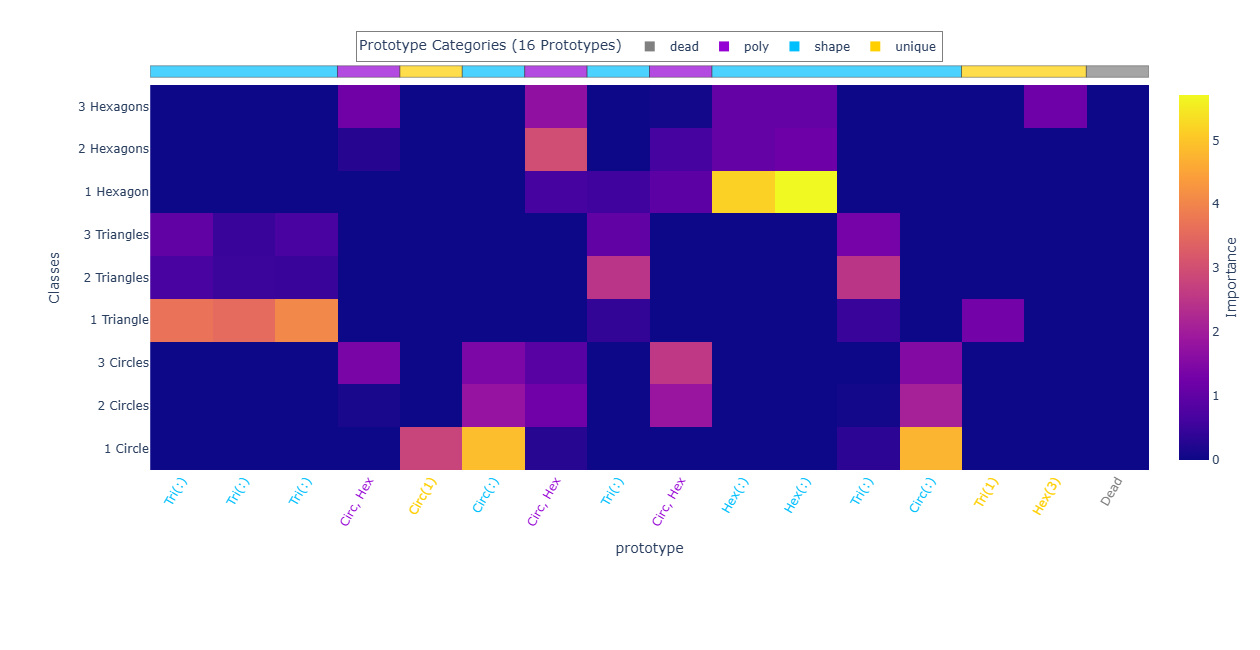

In [58]:
show_global_explanation(net, classes, output_path=run_vis_dir, order_prototypes_by_group=False)

🤖 Deducing prototype groups automatically...
Deduction complete:
  Shape-only: [4]
  Count-only: [0, 3, 11, 14]
  Poly:       []
  Mixed:      [2, 6, 9, 12, 13]
  Unique:     [1, 7, 8, 10]
✅ No overlaps found in group assignments.
ℹ️ Found 2 dead/unassigned prototypes: [5, 15]
Drawing bar for segment: StartIdx=14, EndIdx=15, Color='gray', Group='dead'
Saved annotated global explanation visualization to C:\Edu\Mech_Interp\PIPNet\visualizations\20250407_021157_15_pipnet_s21_stage7_p16\trained_best


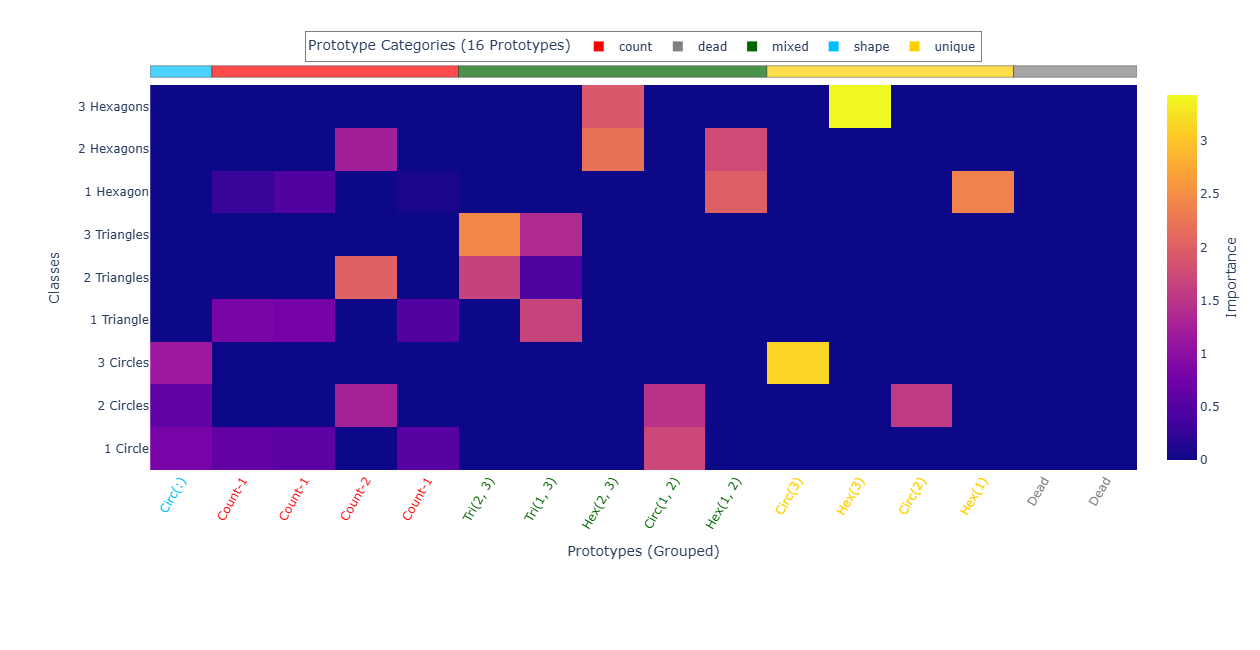

In [41]:
show_global_explanation(net, classes, output_path=run_vis_dir, order_prototypes_by_group=True)